# `HFSModel` Tutorial

Trey V. Wenger (c) November 2024

Here we demonstrate the basic features of the `HFSModel` model. The `HFSModel` models the hyperfine spectral structure of an arbitrary molecule in order to predict the physical conditions of the emitting gas. Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

from bayes_cn_hfs import HFSModel

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.18.2
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.0+3.g2361d26.dirty


## `get_molecule_data`

Here we model the hyperfine structure of CN emission. We use the helper function `get_molecule_data` to download the molecular data for this molecule.

In [2]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
print(mol_data_12CN.keys())
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Upper state degrees of freedom:", mol_data_12CN['degu'])
print("Upper state energy level (erg)", mol_data_12CN['Eu'])
print("Relative intensities", mol_data_12CN['relative_int'])
print("Partition function terms:", mol_data_12CN["log10_Q_terms"])

dict_keys(['freq', 'Aul', 'degu', 'Eu', 'relative_int', 'log10_Q_terms'])
transition frequency (MHz): [113123.3687 113144.19   113170.535  113191.325  113488.142  113490.985
 113499.643  113508.934  113520.4215]
Einstein A coefficient (s-1): [1.26969616e-06 1.03939111e-05 5.07869910e-06 6.59525390e-06
 6.64784064e-06 1.17706070e-05 1.04919208e-05 5.12459350e-06
 1.28243028e-06]
Upper state degrees of freedom: [2 2 4 4 4 6 2 4 2]
Upper state energy level (erg) [7.49702428e-16 7.49701340e-16 7.50014955e-16 7.50013660e-16
 7.52119441e-16 7.51999228e-16 7.52195648e-16 7.52118159e-16
 7.52194276e-16]
Relative intensities [0.01204699 0.09860036 0.09633376 0.1250773  0.12574146 0.33394774
 0.09921527 0.09691221 0.01212491]
Partition function terms: [0.40307694 0.97433601]


## Simulating Data

To test the model, we must simulate some data. We can do this with `HFSModel`, but we must pack a "dummy" data structure first. The model expects the observation to be named `"observation"`.

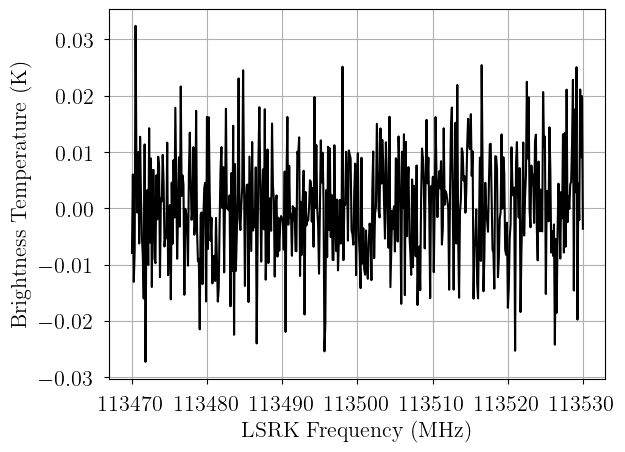

In [3]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis = np.linspace(113470.0, 113530.0, 500) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.01 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood for a given set of model parameters.

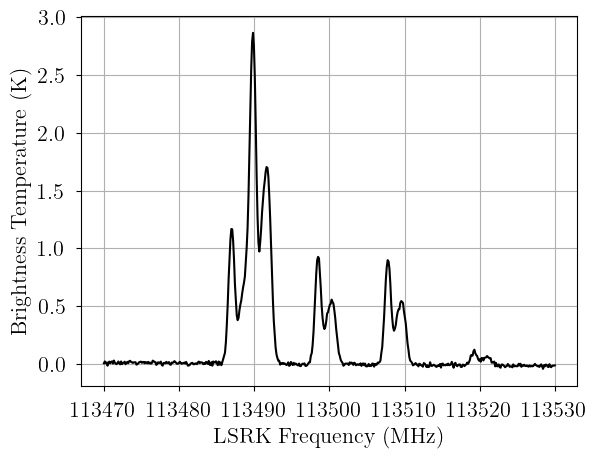

In [4]:
from bayes_cn_hfs import HFSModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = HFSModel(
    dummy_data,
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [14.0, 1.0], # mean and width of log10(N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [0.0, 10.0], # mean and width of velocity prior (km/s)
    prior_rms = 0.1, # width of spectral rms prior (K)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normalized polynomial baseline coeffs
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_brightness = model.model.observation.eval({
    "log10_N": [14.0, 13.5, 14.2],
    "log10_tex": [1.0, 1.2, 1.1],
    "fwhm": [3.0, 2.0, 2.5],
    "velocity": [-2.0, 0.0, 3.0],
    "rms_observation": noise,
    "baseline_observation_norm": [-0.5, -3.0, 2.0], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [5]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `HFSModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = HFSModel(
    data,
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [14.0, 1.0], # mean and width of log10(N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [0.0, 10.0], # mean and width of velocity prior (km/s)
    prior_rms = 0.1, # width of spectral rms prior (K)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normalized polynomial baseline coeffs
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

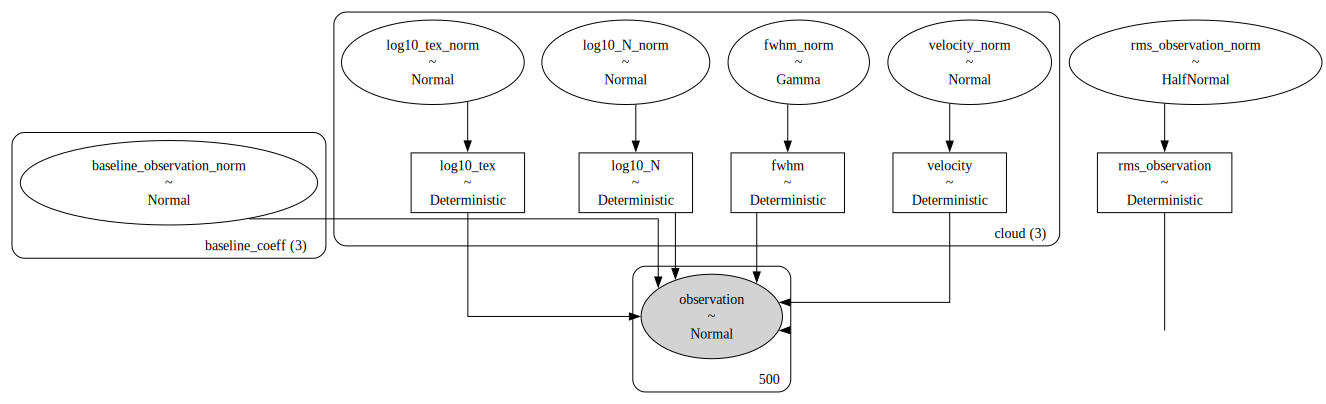

In [7]:
# Plot model graph
model.graph().render('hfs_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

baseline_observation_norm ~ Normal(0, <constant>)
             log10_N_norm ~ Normal(0, 1)
           log10_tex_norm ~ Normal(0, 1)
                fwhm_norm ~ Gamma(2, f())
            velocity_norm ~ Normal(0, 1)
     rms_observation_norm ~ HalfNormal(0, 1)
                  log10_N ~ Deterministic(f(log10_N_norm))
                log10_tex ~ Deterministic(f(log10_tex_norm))
                     fwhm ~ Deterministic(f(fwhm_norm))
                 velocity ~ Deterministic(f(velocity_norm))
          rms_observation ~ Deterministic(f(rms_observation_norm))
              observation ~ Normal(f(baseline_observation_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm), rms_observation)


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [baseline_observation_norm, fwhm_norm, log10_N_norm, log10_tex_norm, observation, rms_observation_norm, velocity_norm]


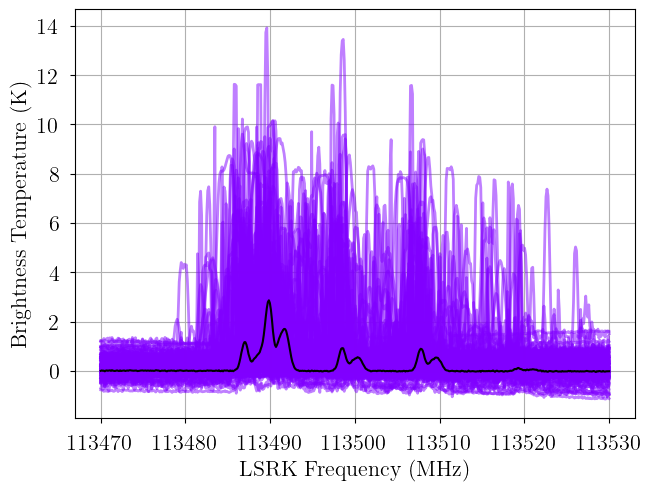

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 4800
Interrupted at 4,799 [4%]: Average Loss = 1,066.4


Output()

Runtime: 0.47 minutes


In [11]:
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N[0],13.960,0.003,13.955,13.965,0.000,0.000,925.0,874.0,NaN
log10_N[1],14.119,0.002,14.116,14.123,0.000,0.000,1059.0,1016.0,NaN
log10_N[2],13.770,0.005,13.759,13.779,0.000,0.000,885.0,878.0,NaN
log10_tex[0],0.988,0.021,0.948,1.029,0.001,0.000,938.0,834.0,NaN
log10_tex[1],1.091,0.009,1.075,1.106,0.000,0.000,1025.0,905.0,NaN
log10_tex[2],0.939,0.042,0.860,1.017,0.001,0.001,1021.0,1026.0,NaN
fwhm[0],3.226,0.021,3.189,3.267,0.001,0.001,603.0,887.0,NaN
fwhm[1],2.321,0.009,2.306,2.338,0.000,0.000,1016.0,854.0,NaN
fwhm[2],5.124,0.077,4.983,5.277,0.003,0.002,948.0,977.0,NaN
velocity[0],-1.904,0.015,-1.934,-1.879,0.000,0.000,1020.0,883.0,NaN


Sampling: [observation]


Output()

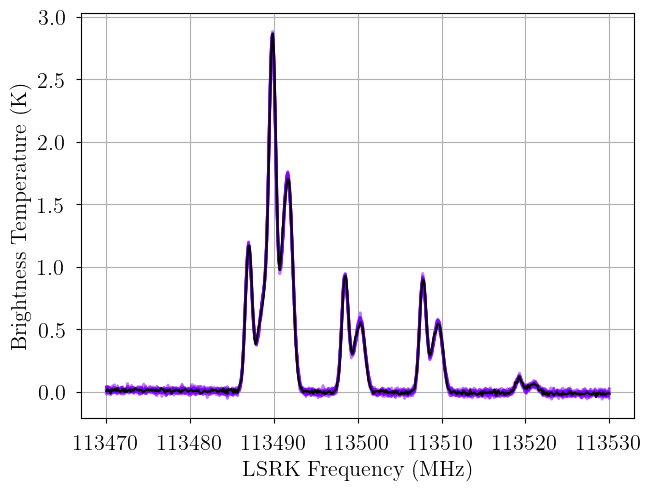

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4800
Interrupted at 4,799 [4%]: Average Loss = 1,066.4
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 388 seconds.


Adding log-likelihood to trace


Output()

There were 72 divergences in converged chains.
Runtime: 7.47 minutes


In [15]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution
3 of 4 chains appear converged.


In [16]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"], var_names=model.cloud_deterministics)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N[0],14.012,0.008,13.996,14.026,0.000,0.000,822.0,850.0,1.0
log10_N[1],14.204,0.003,14.198,14.210,0.000,0.000,1714.0,1797.0,1.0
log10_N[2],13.378,0.035,13.316,13.446,0.001,0.001,839.0,1199.0,1.0
log10_tex[0],1.009,0.015,0.982,1.036,0.000,0.000,2326.0,1633.0,1.0
log10_tex[1],1.114,0.010,1.095,1.131,0.000,0.000,1698.0,1795.0,1.0
log10_tex[2],0.944,0.081,0.792,1.095,0.002,0.001,2213.0,1460.0,1.0
fwhm[0],3.049,0.035,2.981,3.111,0.001,0.001,845.0,1058.0,1.0
fwhm[1],2.510,0.008,2.495,2.524,0.000,0.000,1918.0,2081.0,1.0
fwhm[2],1.928,0.059,1.817,2.039,0.002,0.001,942.0,1432.0,1.0
velocity[0],-1.967,0.025,-2.018,-1.922,0.001,0.001,835.0,872.0,1.0


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [observation]


Output()

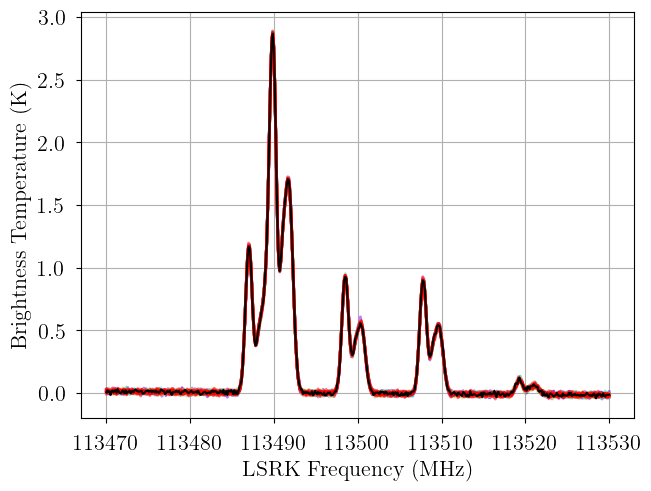

In [17]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

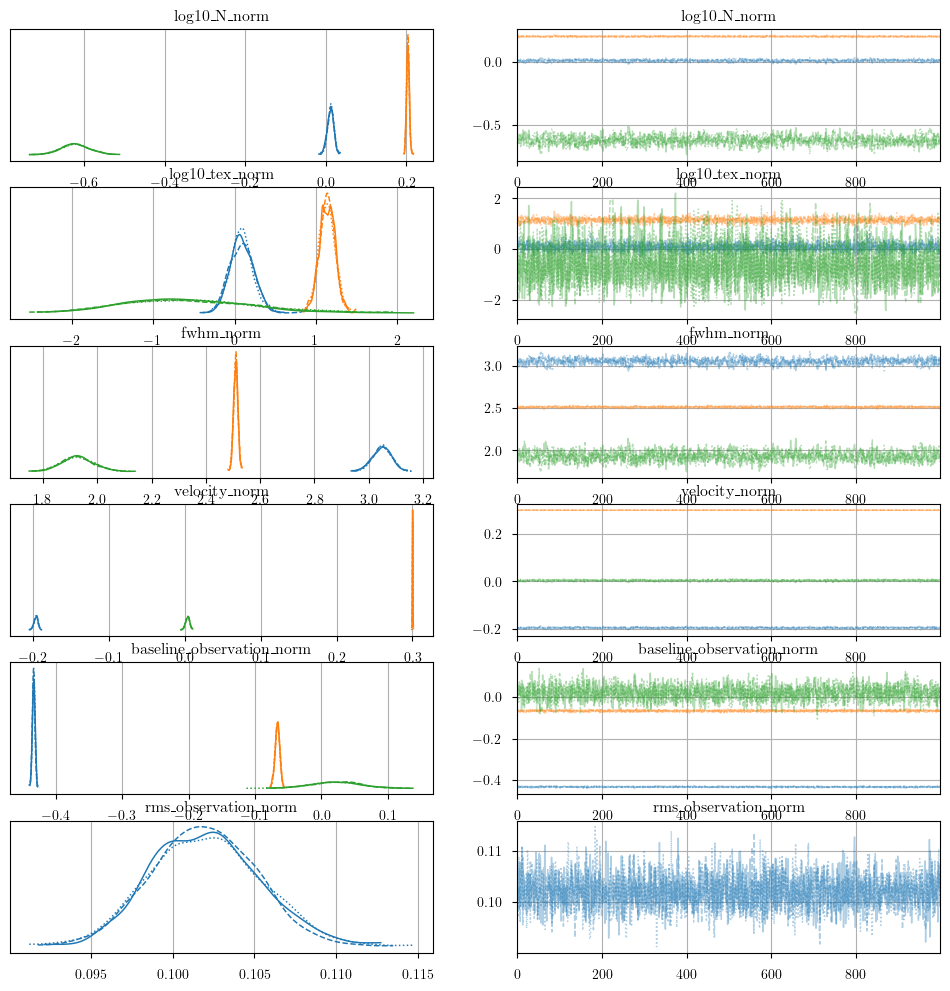

In [18]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

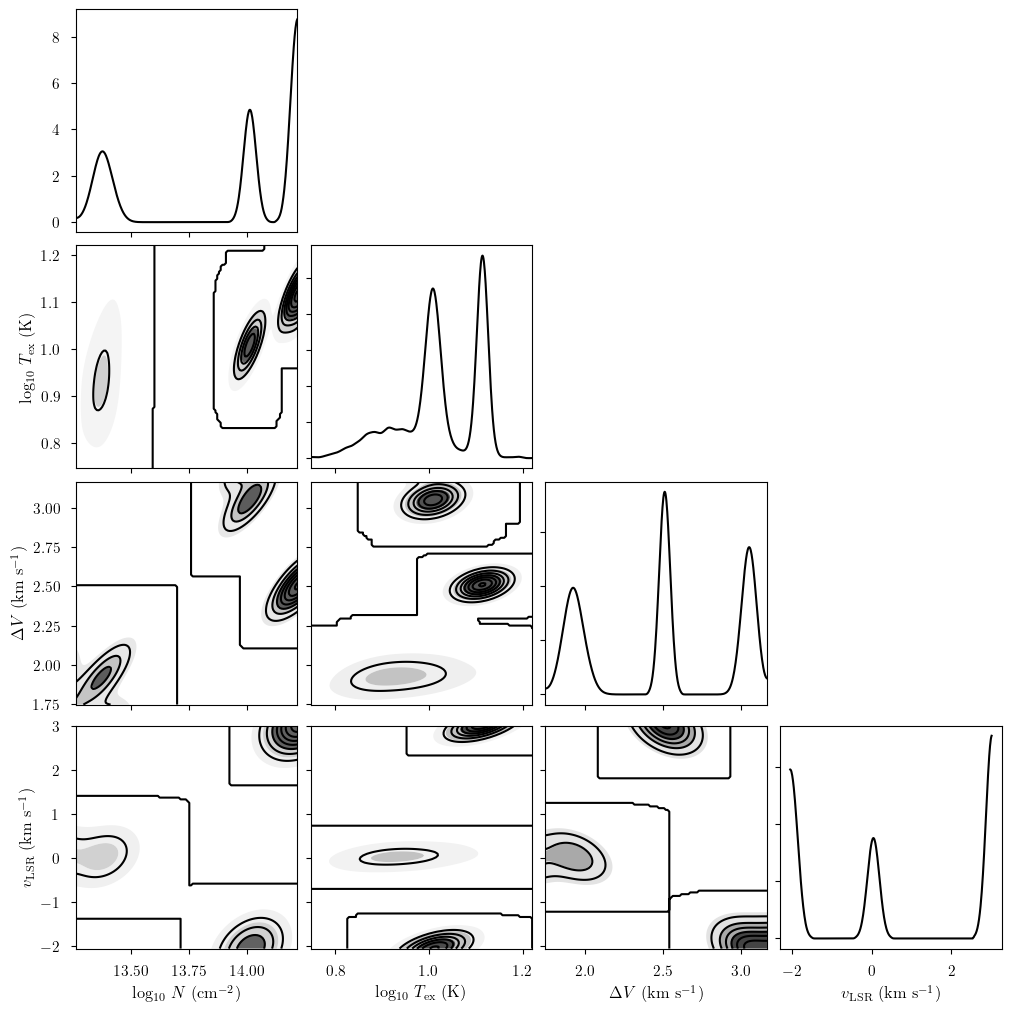

In [19]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the spectral rms hyper parameter).

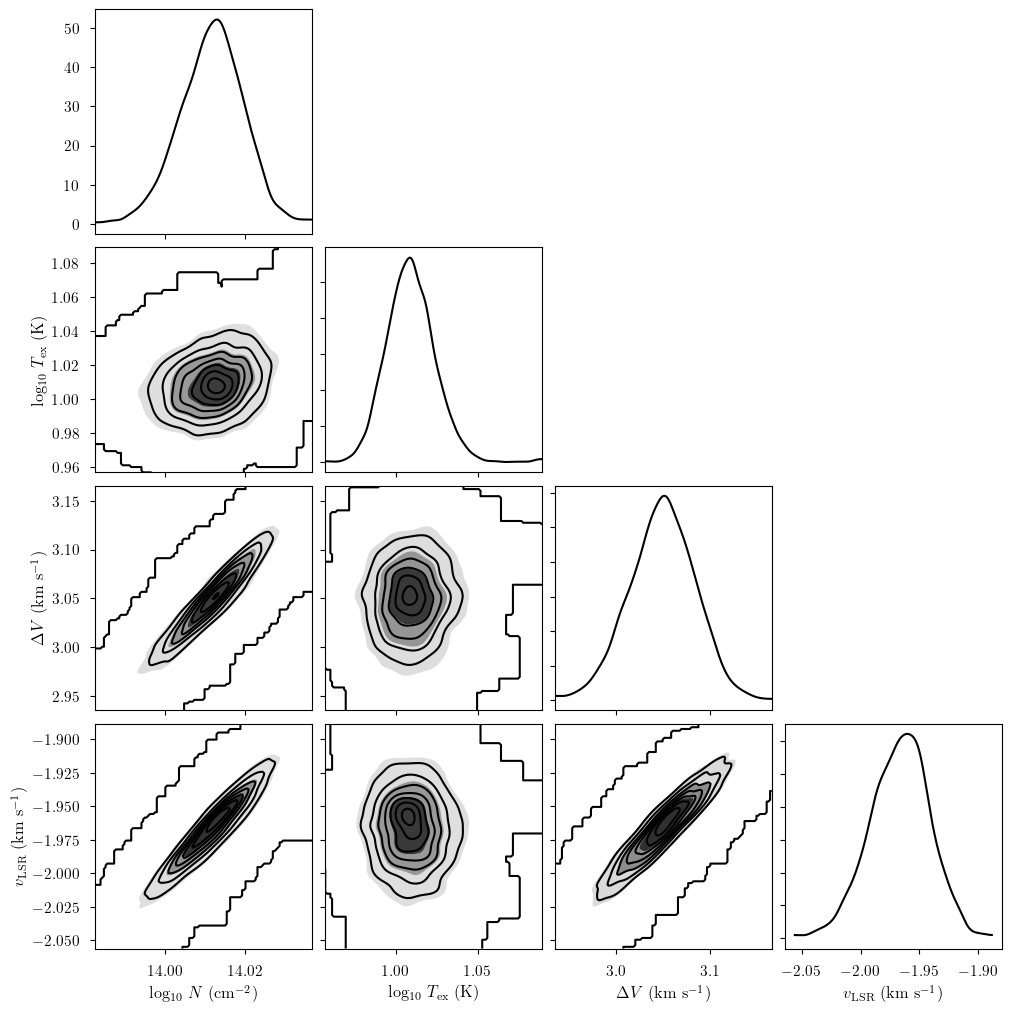

In [20]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [21]:
point_stats = az.summary(model.trace.solution_0, var_names=model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -3067.119948814445


,mean,sd,hdi_16%,hdi_84%
log10_N[0],14.012,0.008,14.004,14.020
log10_N[1],14.204,0.003,14.200,14.207
log10_N[2],13.378,0.035,13.344,13.412
log10_tex[0],1.009,0.015,0.994,1.022
log10_tex[1],1.114,0.010,1.106,1.125
log10_tex[2],0.944,0.081,0.861,1.020
fwhm[0],3.049,0.035,3.019,3.087
fwhm[1],2.510,0.008,2.502,2.517
fwhm[2],1.928,0.059,1.865,1.981
velocity[0],-1.967,0.025,-1.990,-1.941
